<a href="https://colab.research.google.com/github/menduv/mtg-Jamendo/blob/main/CNN_mtg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/colab_data/trail_download_archive_6gb.zip","r") as zip_ref:
    zip_ref.extractall("/content/sample_mel")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
import os

print('The number of mel-spectrogram in the sample_mel folder is:',len(os.listdir('/content/sample_mel')))

The number of mel-spectrogram in the sample_mel folder is: 1991


In [5]:
mel_dir = '/content/sample_mel'
mel_list = os.listdir(mel_dir)
mel_npy = np.load(f'{mel_dir}/{mel_list[25]}')
# print('Count of npy files: ', len(mel_list))
print('Size of image: ', mel_npy.shape)

Size of image:  (96, 4001)


# Loading the mtg dataframe and filtering it to include top 5 genres from the 6gb sample

In [6]:
data = pd.read_csv('/content/mtg_cleaned.csv', index_col = [0])

In [7]:
data

,track_id,artist_id,album_id,path,duration,genre,instrument,mood
1,214,14,31,14/214.mp3,124.6,punkrock,NaN,NaN
2,215,14,31,15/215.mp3,151.4,metal,NaN,NaN
3,216,14,31,16/216.mp3,234.9,metal,NaN,NaN
4,217,14,31,17/217.mp3,127.9,punkrock,NaN,NaN
5,218,14,31,18/218.mp3,180.7,punkrock,NaN,NaN
...,...,...,...,...,...,...,...,...
55605,1422056,496314,165847,56/1422056.mp3,516.0,soundtrack,computer,"advertising, dramatic, epic, movie"
55606,1422057,496314,165847,57/1422057.mp3,374.9,soundtrack,computer,"advertising, dramatic, epic, movie"
55607,1422058,496314,165847,58/1422058.mp3,315.8,soundtrack,computer,"dramatic, epic, movie"
55608,1422059,496314,165847,59/1422059.mp3,201.3,soundtrack,computer,"advertising, dramatic, epic, movie"


In [8]:
#list of all the track_ids in the sample
track_ids = [int(file_name.replace('.npy', '')) for file_name in mel_list]

#filtering only those tracks to the dataset
df = data[data['track_id'].isin(track_ids)]

#only taking the first genre
df['genre'] = df['genre'].str.split(',').str[0]

#only keeping the tracks and genre column
df = df[['track_id', 'genre']]

<ipython-input-8-d8a67b564b4f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genre'] = df['genre'].str.split(',').str[0]


In [9]:
#calculating the most frequent genres in the sample and only keeping the top five in the df
df_genre = pd.DataFrame(df.genre.value_counts().rename_axis('genre').reset_index(name='counts'))

#list of top five genres
top_genres = list(df_genre.genre[:5])

#filtering df to only keep
df = df[df['genre'].isin(top_genres)].reset_index(drop = True)

df

,track_id,genre
0,6606,dance
1,6607,dance
2,6608,dance
3,6609,dance
4,7401,easylistening
...,...,...
1011,1419109,ambient
1012,1420409,dance
1013,1420704,dance
1014,1420705,dance


In [10]:
#List of all the track_ids that are in the sample and have top5
train_track_ids = list(df['track_id'].values)

# Cropping mel-spectrograms to the size (96, 1406)

In [11]:
!mkdir '/content/cropped_mel'

In [12]:
def crop_melspectrogram(mel_spectrogram, target_frames, hop_size):
    # Crop or pad the mel spectrogram to the target number of frames
    if mel_spectrogram.shape[1] >= target_frames:
        cropped_mel_spectrogram = mel_spectrogram[:, :target_frames]
    else:
        # Pad with zeros if the original length is less than the target
        padding = np.zeros((mel_spectrogram.shape[0], target_frames - mel_spectrogram.shape[1]))
        cropped_mel_spectrogram = np.hstack((mel_spectrogram, padding))

    return cropped_mel_spectrogram


In [26]:
folder_path = '/content/sample_mel'
cropped_folder_path = '/content/cropped_mel'

# Assuming the hop size used during mel spectrogram calculation
hop_size = 256
sample_rate = 12000

# Calculate the target number of frames based on the desired duration (e.g., 30 seconds)
desired_duration_seconds = 30
target_frames = int(desired_duration_seconds * (1 / (hop_size / sample_rate)))

# Iterate over files in the folder
for filename in train_track_ids:
    file_path = os.path.join(folder_path, str(filename) +'.npy')

    mel_spectrogram = np.load(file_path)

    cropped_mel_spectrogram = crop_melspectrogram(mel_spectrogram, target_frames, hop_size)

    np.save(os.path.join(cropped_folder_path, str(filename)), cropped_mel_spectrogram)

In [27]:
print('The number of cropped mel-spectrogram in the cropped_mel folder is:',len(os.listdir('/content/cropped_mel')))

The number of cropped mel-spectrogram in the cropped_mel folder is: 1016


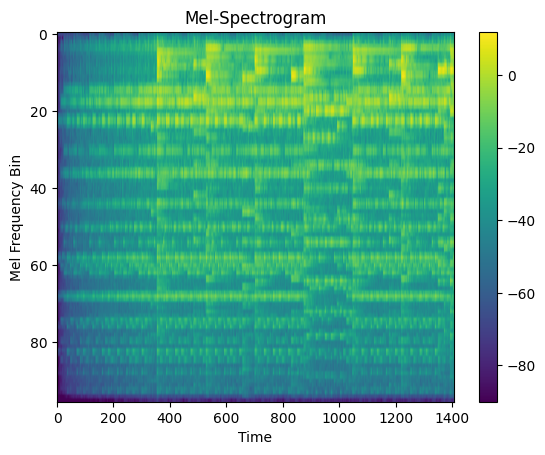

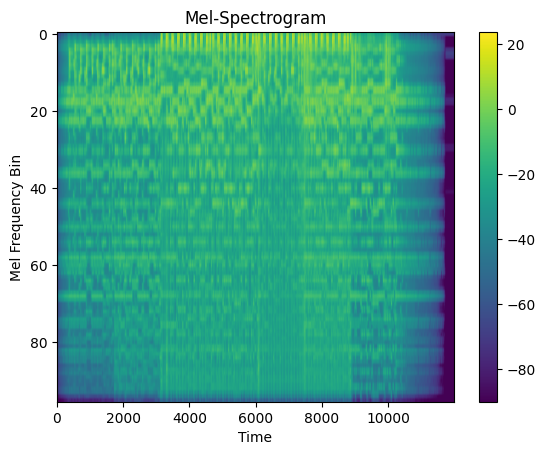

In [28]:
'''To display cropped and original mels'''

crop_mel_307 = np.load('/content/cropped_mel/1001307.npy')
mel_307 = np.load('/content/sample_mel/1001307.npy')

plt.imshow(crop_mel_307, aspect='auto')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bin')
plt.title('Mel-Spectrogram')
plt.colorbar()
plt.show()

plt.imshow(mel_307, aspect='auto')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bin')
plt.title('Mel-Spectrogram')
plt.colorbar()
plt.show()

# Training the model

In [39]:
#loading the cropped .npy files

folder_path_cropped = '/content/cropped_mel'
filenames = os.listdir(folder_path_cropped)

data = []

for filename in filenames:
  file_path = os.path.join(folder_path_cropped,filename)
  data.append(np.load(file_path))

data = np.array(data)

In [40]:
#normalize data
data = data.astype('float32')/255.0

In [41]:
from sklearn.model_selection import train_test_split

# Reshape data to include the channel dimension
data = data.reshape((-1, 96, 1406, 1))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, pd.get_dummies(df['genre']), test_size=0.2, random_state=42)

In [42]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 1406, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [44]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
26/26 [==============================] - 216s 8s/step - loss: 2.7798 - accuracy: 0.3030 - val_loss: 1.5481 - val_accuracy: 0.3333
Epoch 2/10
26/26 [==============================] - 217s 8s/step - loss: 1.5214 - accuracy: 0.3399 - val_loss: 1.5370 - val_accuracy: 0.3333
Epoch 3/10
26/26 [==============================] - 218s 8s/step - loss: 1.5133 - accuracy: 0.3350 - val_loss: 1.5439 - val_accuracy: 0.3333
Epoch 4/10
26/26 [==============================] - 222s 8s/step - loss: 1.5148 - accuracy: 0.3411 - val_loss: 1.5542 - val_accuracy: 0.3333
Epoch 5/10
26/26 [==============================] - 203s 8s/step - loss: 1.5093 - accuracy: 0.3399 - val_loss: 1.5491 - val_accuracy: 0.3333
Epoch 6/10
26/26 [==============================] - 213s 8s/step - loss: 1.5046 - accuracy: 0.3202 - val_loss: 1.5464 - val_accuracy: 0.3333
Epoch 7/10
26/26 [==============================] - 214s 8s/step - loss: 1.5105 - accuracy: 0.3264 - val_loss: 1.5544 - val_accuracy: 0.2353
Epoch 8/10
26

In [48]:
import keras
# Save the entire model to a file
model.save('/content/drive/MyDrive/colab_data/simple_cnn.keras')

# Load the model back
loaded_model = keras.models.load_model('/content/drive/MyDrive/colab_data/simple_cnn.keras')

In [45]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

7/7 [==============================] - 12s 2s/step - loss: 1.5737 - accuracy: 0.3333
Validation Loss: 1.5737334489822388, Validation Accuracy: 0.3333333432674408
